# Topic Modelling

Please note that the work below relies on data files I no longer have access to (only samples of which I have saved).

The goal of this work is to produce visualisations and insights that could be shared with our client to show what common themes/products/services are being referred to by customers in their reviews so that the client can direct resources towards improving those that are mentioned in a negative context (as informed by further work on the polarity and subjectivity of reviews).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import pyLDAvis, pyLDAvis.sklearn, pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV

In [ ]:
fields = ['field_1', 'field_2', 'field_3']

In [63]:
def remove_all_stopwords(text):
    tokens = [word for word in text.split() if word not in stopwords.words('english')]
    return ' '.join(tokens)

## Latent Dirichlet Allocation

LDA assumes that each document i.e. review contains a mixture of topics. As such, reviews have not been split and tokenised into sentences.

LDA also requires choosing the number of topics (n) manually, which is chosen based on domain knowledge or EDA - for now it's been set to 5.

### Approach 1

In [23]:
selected_field = fields[0]
df = pd.read_csv(f'path/to/{selected_field}.csv')
df.head()

,review_year,review_month,review_text,processed_review_text
0,2021,Oct,The ticketing process and hiring process was g...,ticket process hire process be great easy all ...
1,2021,Aug,"Excellent team, thank you Laura and the girl d...",excellent team thank you laura girl driver who...
2,2021,Jul,"Won’t go back in a hurry. Massive long lines, ...",will not go back in hurry massive long line sh...
3,2021,Mar,We spent 2 hours on the ski field riding the m...,we spent 2 hour on ski field rid mountain cart...
4,2021,Feb,Visited as a group of 4 couples and everyone h...,visit a group of 4 couple everyone have an abs...


In [24]:
df['processed_review_text'] = df['processed_review_text'].apply(lambda x: remove_all_stopwords(x))

In [52]:
# training LDA model to find a specified number of topics
processed_reviews = [df['processed_review_text'][i].split() for i in range(df.shape[0])]
dictionary = corpora.Dictionary(processed_reviews)
corpus = [dictionary.doc2bow(review) for review in processed_reviews]
model = models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic[1])

0.017*"day" + 0.015*"great" + 0.015*"ski" + 0.013*"cardrona" + 0.011*"time"
0.016*"day" + 0.016*"ski" + 0.012*"cardrona" + 0.011*"get" + 0.009*"time"
0.018*"great" + 0.015*"staff" + 0.015*"ski" + 0.014*"mountain" + 0.011*"get"
0.019*"ski" + 0.015*"cardrona" + 0.014*"day" + 0.012*"get" + 0.012*"great"
0.008*"ski" + 0.008*"staff" + 0.007*"cardrona" + 0.006*"lift" + 0.006*"resort"


### Approach 2

This refined approach treats the number of topics as a hyperparameter in a cross-validation procedure with perplexity as the evaluation metric so that an optimal number of topics are  found (too few and there may not be enough nuance captured, but too many and the outputs may become less interpretable).

In [40]:
selected_field = fields[0]
df = pd.read_csv(f'path/to/{selected_field}.csv')
df.head()

,review_year,review_month,review_text,processed_review_text
0,2021,Oct,The ticketing process and hiring process was g...,ticket process hire process be great easy all ...
1,2021,Aug,"Excellent team, thank you Laura and the girl d...",excellent team thank you laura girl driver who...
2,2021,Jul,"Won’t go back in a hurry. Massive long lines, ...",will not go back in hurry massive long line sh...
3,2021,Mar,We spent 2 hours on the ski field riding the m...,we spent 2 hour on ski field rid mountain cart...
4,2021,Feb,Visited as a group of 4 couples and everyone h...,visit a group of 4 couple everyone have an abs...


In [41]:
def remove_all_stopwords(text):
    stops = stopwords.words('english')
    tokens = [word for word in text.split() if word not in stops]
    return str(tokens)

df['processed_review_text'] = df['processed_review_text'].apply(lambda x: remove_all_stopwords(x))
df.head()

,review_year,review_month,review_text,processed_review_text
0,2021,Oct,The ticketing process and hiring process was g...,"[ticket, process, hire, process, great, easy, ..."
1,2021,Aug,"Excellent team, thank you Laura and the girl d...","[excellent, team, thank, laura, girl, driver, ..."
2,2021,Jul,"Won’t go back in a hurry. Massive long lines, ...","[go, back, hurry, massive, long, line, short, ..."
3,2021,Mar,We spent 2 hours on the ski field riding the m...,"[spent, 2, hour, ski, field, rid, mountain, ca..."
4,2021,Feb,Visited as a group of 4 couples and everyone h...,"[visit, group, 4, couple, everyone, absolute, ..."


#### Create document-word matrix

In [47]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', ngram_range=(2,2), lowercase=False)  
matrix = vectorizer.fit_transform(df.processed_review_text.values)

In [51]:
# Compute density (percentage of non-zero values in matrix - most values will be zero)
data_dense = matrix.todense()
print(f"Density: {((data_dense > 0).sum()/data_dense.size)*100:.2f}%")

Density: 0.19%


#### Grid search to tune hyperparameters

In [58]:
# Tune n_components (number of topics), learning_decay (learning rate) 
# can also try learning_offset (downweigh early iterations, should be > 1), max_iter, and others
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
lda_model_tuned = LatentDirichletAllocation()
gs = GridSearchCV(lda_model_tuned, param_grid=search_params)
gs.fit(matrix)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [59]:
# Good model = high log likelihood, low perplexity (e^-log_likelihood_per_word)

best_lda_model = gs.best_estimator_
print("Parameter values: ", gs.best_params_)
print("Log likelihood: ", gs.best_score_)
print("Perplexity: ", best_lda_model.perplexity(matrix))

Parameter values:  {'learning_decay': 0.7, 'n_components': 10}
Log likelihood score:  -23584.961340219015
Model perplexity:  2791761.8129768637


#### Build LDA model

In [64]:
lda_model = LatentDirichletAllocation(n_components=10, learning_decay = 0.7, random_state=100)
lda_output = lda_model.fit_transform(matrix)
print("Parameter values: ", lda_model.get_params())
print("Log likelihood: ", lda_model.score(matrix))
print("Perplexity: ", lda_model.perplexity(matrix))

Parameter values:  {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Log likelihood:  -66609.20437894973
Perplexity:  2825962.8142750976


In [69]:
# Top 5 bigrams with the highest probabilities for each of the 10 topics
for i, topic in enumerate(lda_model.components_):
    print(f'Top 5 bigrams for topic {i+1}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-5:]])

Top 5 bigrams for topic 1:
['day skiing', 'time cardrona', 'ski resort', 'first time', 'great day']
Top 5 bigrams for topic 2:
['drive queenstown', 'make sure', 'kid club', 'highly recommend', 'really good']
Top 5 bigrams for topic 3:
['come back', 'still great', 'ski hire', 'white star', 'ski field']
Top 5 bigrams for topic 4:
['well worth', 'day skiing', 'ski field', 'ski resort', 'first time']
Top 5 bigrams for topic 5:
['ski resort', 'school holiday', 'would recommend', 'friendly staff', 'ski field']
Top 5 bigrams for topic 6:
['whole family', 'come back', 'ski field', 'year old', 'highly recommend']
Top 5 bigrams for topic 7:
['great coffee', 'first time', 'valley view', 'great place', 'ski field']
Top 5 bigrams for topic 8:
['customer service', 'ski lesson', 'coronet peak', 'instructor helpful', 'first time']
Top 5 bigrams for topic 9:
['never ski', 'super helpful', 'first time', 'ski instructor', 'staff friendly']
Top 5 bigrams for topic 10:
['first time', 'ski field', 'skiing c

We can start to see some overarching topics being found, particularly topic 6 (which seems to be relating to how family-friendly the ski field is), topic 8 (relating to customer service), topic 9 (relating to beginner-friendliness)

#### Visualise model

Trying to visualise the principal components that constitute the model

In [73]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, matrix, vectorizer, mds='tsne')
# pyLDAvis.save_html(panel, 'topic_lda_sklearn.html')
panel

g:\My Drive\Professional\Internship and Graduate\2021\Qrious\Project 3  NZ Ski Sentiment Analysis\nzski\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
g:\My Drive\Professional\Internship and Graduate\2021\Qrious\Project 3  NZ Ski Sentiment Analysis\nzski\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
g:\My Drive\Professional\Internship and Graduate\2021\Qrious\Project 3  NZ Ski Sentiment Analysis\nzski\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
g:\My Drive\Professiona

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  11.320479
4       0.648955  71.707100       2        1  10.652610
6      71.019684   9.971006       3        1  10.524459
0       3.785981  33.185135       4        1  10.473754
8     -42.666500  -9.222070       5        1  10.390879
9      -3.621689 -43.526516       6        1  10.271547
3      -3.632402  -4.171708       7        1   9.499302
5     -36.584400  35.804413       8        1   9.227086
2      44.391380  50.615383       9        1   8.961669
7      40.235809 -31.591665      10        1   8.678216, topic_info=                   Term      Freq     Total Category  logprob  loglift
10651  highly recommend  0.000000  0.000000  Default  30.0000  30.0000
4482          come back  0.000000  0.000000  Default  29.0000  29.0000
9970        great staff  0.000000  0.000000  Default  28.0000  28.0000
25281        white star  0.000000  0.000000  Default  27.0000  27.0000
8870     friendly staff  0.000000  0.000000  Default  26.0000  26.0000
...                 ...       ...       ...      ...      ...      ...
3475       cardrona ski  0.063899  0.540212  Topic10  -8.7144   0.3097
20215         ski field  0.062834  1.202782  Topic10  -8.7312  -0.5075
14979         next year  0.056637  0.398121  Topic10  -8.8350   0.4943
9944       great resort  0.055673  0.268592  Topic10  -8.8522   0.8707
21652        staff help  0.055488  0.289910  Topic10  -8.8555   0.7910

[576 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 1, 9, 10, 4, 6, 3, 8])

## Non-negative Matrix Factorisation

NMF uses the TF-IDF document-term matrix to output a document-topic matrix i.e. a matrix describing the distribution of topics in each document.

### Approach 1

In [3]:
selected_field = fields[0]
df = pd.read_csv(f'path/to/{selected_field}.csv')
df.head()

,review_year,review_month,review_text,processed_review_text
0,2021,Oct,The ticketing process and hiring process was g...,ticket process hire process be great easy all ...
1,2021,Aug,"Excellent team, thank you Laura and the girl d...",excellent team thank you laura girl driver who...
2,2021,Jul,"Won’t go back in a hurry. Massive long lines, ...",will not go back in hurry massive long line sh...
3,2021,Mar,We spent 2 hours on the ski field riding the m...,we spent 2 hour on ski field rid mountain cart...
4,2021,Feb,Visited as a group of 4 couples and everyone h...,visit a group of 4 couple everyone have an abs...


In [4]:
df['processed_review_text'] = df['processed_review_text'].apply(lambda x: remove_all_stopwords(x))
df.head()

,review_year,review_month,review_text,processed_review_text
0,2021,Oct,The ticketing process and hiring process was g...,ticket process hire process great easy staff h...
1,2021,Aug,"Excellent team, thank you Laura and the girl d...",excellent team thank laura girl driver full fu...
2,2021,Jul,"Won’t go back in a hurry. Massive long lines, ...",go back hurry massive long line short run marg...
3,2021,Mar,We spent 2 hours on the ski field riding the m...,spent 2 hour ski field rid mountain cart hoot ...
4,2021,Feb,Visited as a group of 4 couples and everyone h...,visit group 4 couple everyone absolute blast u...


In [6]:
processed_reviews = [df['processed_review_text'][i].split() for i in range(df.shape[0])]

In [19]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', ngram_range=(2,2), lowercase=False, 
min_df=5, # don't want terms to be used that don't appear often
stop_words='english' # not checking non-English stopwords for now
)
matrix = vectorizer.fit_transform(df.processed_review_text.values)

nmf = NMF(n_components=40, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(matrix)

g:\My Drive\Professional\Internship and Graduate\2021\Qrious\Project 3  NZ Ski Sentiment Analysis\nzski\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=40, random_state=1)

Using NMF, we can roughly see topics like facilities and amenities (2, 3, 4), staff (6, 7), and overall impresions (1, 8)

In [26]:
feature_names = vectorizer.get_feature_names()
n_top_words = 10

df_topic_dict = {}
for idx, topic in enumerate(nmf.components_[:10]):
    topic_id = f'topic_{idx+1}'
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    df_topic_dict[topic_id] = top_words
df_topic = pd.DataFrame(df_topic_dict)
df_topic

g:\My Drive\Professional\Internship and Graduate\2021\Qrious\Project 3  NZ Ski Sentiment Analysis\nzski\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,ski field,staff friendly,cardrona ski,ski resort,staff helpful,great day,friendly staff,alpine resort,feel like,really good
1,best ski,ski area,stun view,best ski,helpful friendly,day skiing,staff great,cardrona alpine,day day,good fun
2,family ski,hot chocolate,trip cardrona,staff great,food drink,great run,helpful friendly,resort amaze,mountain great,overall great
3,cardrona best,skiing time,lesson good,cart fun,drive mountain,day ski,rental gear,great staff,skiing experience,mountain great
4,view ski,food choice,lift great,great run,ski time,kid adult,great run,thanks great,spent hour,winter game
5,ski season,car park,day cardrona,bus ride,lesson kid,year ski,groom run,beginner expert,make feel,great resort
6,day ski,time visit,fun family,resort amaze,snow condition,noodle bar,great instructor,easy access,staff member,ski slope
7,great ski,spent day,worth drive,cardrona best,car park,learn ski,different level,great view,afternoon lesson,lesson instructor
8,beginner expert,trip cardrona,noodle bar,view amaze,good snow,overall great,really friendly,good experience,time mountain,pretty good
9,magic carpet,awesome time,staff come,ski time,staff help,family great,absolute beginner,plenty time,alpine resort,good value


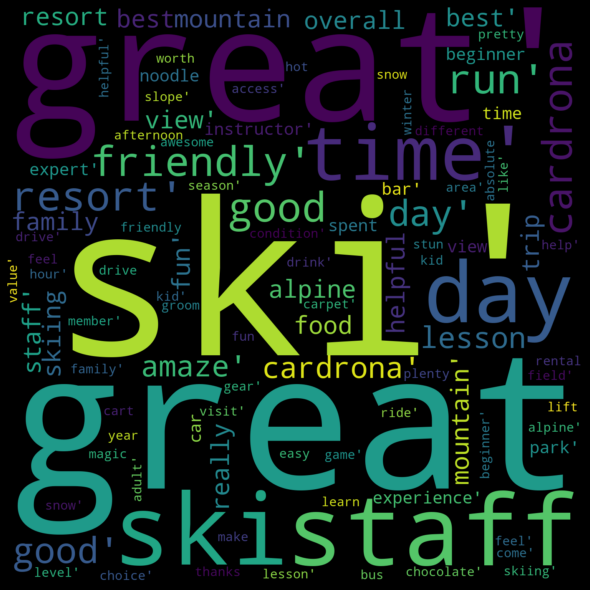

In [31]:
text = df_topic.values
wordcloud = WordCloud(width=1500, height=1500, background_color='black', stopwords=STOPWORDS).generate(str(text))
fig = plt.figure( figsize=(8,8), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Approach 2

This approach consists of applying LDA first to find the optimal number of topics ("components" in NMF terminology) and then using an NMF model + business domain knowledge to determine what topics are present in the reviews

The first part of this approach was largely inspired by: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

#### 2a

In [3]:
tokenised_df = pd.read_csv('/path/to/all_tokenised_reviews.csv')
tokenised_df.head()

,review_year,review_month,peak,tokenised_sentences,subjectivity,sentiment,sentiment_score
0,2021,Oct,cardrona,ticket process hire process be great easy all ...,0.569444,POSITIVE,0.990033
1,2021,Oct,cardrona,all be well until we meet out instructor (nick...,0.668750,NEGATIVE,-0.993660
2,2021,Oct,cardrona,it completely put our kid off.,0.400000,NEGATIVE,-0.995861
3,2021,Oct,cardrona,we then go do our own lesson with kid with lit...,0.566667,NEGATIVE,-0.938372
4,2021,Oct,cardrona,over all cadrona be well set up for first time...,0.477778,POSITIVE,0.970559


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = tokenised_df.tokenised_sentences.values.tolist()
data_words = list(sent_to_words(data))

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [6]:
# Define functions for stopwords, bigrams, trigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords.words('english')] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
# Corpus and Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3)]]


In [9]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [10]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"drive" + 0.042*"queenstown" + 0.042*"bus" + 0.037*"view" + '
  '0.036*"mountain" + 0.036*"road" + 0.031*"get" + 0.029*"top" + 0.023*"park" '
  '+ 0.023*"car"'),
 (1,
  '0.080*"coronet" + 0.074*"peak" + 0.026*"ski" + 0.024*"small" + '
  '0.023*"resort" + 0.021*"area" + 0.021*"found" + 0.018*"nz" + 0.017*"base" + '
  '0.013*"big"'),
 (2,
  '0.125*"day" + 0.088*"skiing" + 0.075*"time" + 0.050*"first" + 0.023*"love" '
  '+ 0.023*"ski" + 0.023*"go" + 0.019*"end" + 0.017*"one" + 0.017*"kid"'),
 (3,
  '0.138*"snow" + 0.049*"fun" + 0.037*"much" + 0.029*"good" + 0.029*"make" + '
  '0.025*"look" + 0.024*"season" + 0.022*"get" + 0.020*"well" + 0.018*"go"'),
 (4,
  '0.065*"ski" + 0.039*"field" + 0.027*"go" + 0.026*"would" + 0.023*"one" + '
  '0.022*"like" + 0.022*"see" + 0.020*"could" + 0.016*"many" + 0.015*"people"'),
 (5,
  '0.091*"great" + 0.054*"staff" + 0.036*"good" + 0.031*"friendly" + '
  '0.031*"ski" + 0.029*"facility" + 0.024*"helpful" + 0.024*"really" + '
  '0.023*"instruc

In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3538898534816841


In [39]:
def compute_coherence_values(corpus, dictionary, k):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=a,
                                           eta=b, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [26]:
model_results = {'Topics': [], 'Coherence': []}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
for k in range(min_topics, max_topics, step_size):
    # get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

Using coherence score, we can see that beyond 5-6 topics, topic interpretability seems to drop, so modelling efforts where this parameter can be specified (like in LDA above) may perform better with this many topics.

<AxesSubplot:xlabel='Topics'>

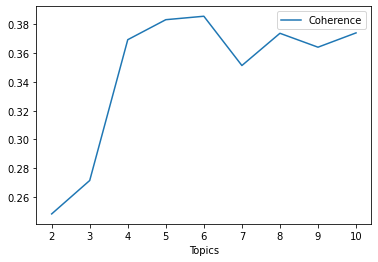

In [33]:
d = pd.DataFrame(model_results)
d.plot.line(x='Topics', y='Coherence')

In [40]:
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

tuned_results = {'Alpha': [], 'Beta': [], 'Coherence': []}

for a in alpha:
    for b in beta:
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=6, a=a, b=b)
        tuned_results['Alpha'].append(a)
        tuned_results['Beta'].append(b)
        tuned_results['Coherence'].append(cv)

In [45]:
pd.DataFrame(tuned_results)[pd.DataFrame(tuned_results)['Coherence'] == max(tuned_results['Coherence'])]

,Alpha,Beta,Coherence
28,asymmetric,0.91,0.469025


In [47]:
# final model using tuned hyperparameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.9)

In [55]:
# Print the keywords in the topics
pprint(lda_model.print_topics())

[(0,
  '0.026*"ski" + 0.019*"day" + 0.017*"great" + 0.017*"snow" + 0.015*"get" + '
  '0.012*"good" + 0.011*"go" + 0.011*"run" + 0.011*"time" + 0.010*"skiing"'),
 (1,
  '0.033*"staff" + 0.022*"instructor" + 0.020*"friendly" + 0.017*"helpful" + '
  '0.010*"help" + 0.007*"centre" + 0.006*"patient" + 0.006*"learner" + '
  '0.005*"us" + 0.005*"make"'),
 (2,
  '0.031*"food" + 0.019*"cafe" + 0.012*"lunch" + 0.011*"new" + '
  '0.011*"building" + 0.011*"green" + 0.010*"good" + 0.009*"expensive" + '
  '0.009*"base" + 0.009*"facility"'),
 (3,
  '0.011*"either" + 0.008*"local" + 0.008*"boarding" + 0.005*"happen" + '
  '0.005*"wow" + 0.005*"bought" + 0.004*"carpet" + 0.004*"skiiers" + '
  '0.004*"dump" + 0.004*"easily"'),
 (4,
  '0.024*"road" + 0.017*"line" + 0.008*"ice" + 0.007*"windy" + 0.007*"avoid" + '
  '0.006*"low" + 0.006*"wd" + 0.006*"card" + 0.005*"gravel" + 0.005*"km"'),
 (5,
  '0.011*"thanks" + 0.005*"carry" + 0.005*"cater" + 0.004*"pleasant" + '
  '0.003*"caters" + 0.003*"whether" + 0.0

In [56]:
doc_lda

In [52]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\Users\Nick\Documents\d998_nzski_sentiment_analysis\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.315455 -0.029355       1        1  70.614717
1     -0.065154 -0.117847       2        1  10.507720
2      0.002077  0.162090       3        1  10.061401
4     -0.082844 -0.011833       4        1   3.879419
3     -0.086666 -0.003090       5        1   2.927745
5     -0.082869  0.000034       6        1   2.008999, topic_info=            Term        Freq       Total Category  logprob  loglift
10         staff  600.000000  600.000000  Default  30.0000  30.0000
87          road  456.000000  456.000000  Default  29.0000  29.0000
223         food  418.000000  418.000000  Default  28.0000  28.0000
23    instructor  339.000000  339.000000  Default  27.0000  27.0000
142     friendly  336.000000  336.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
7251         kim    2.456911    8.177995   Topic6  -6.9795   2.7050
138       unique    2.415748    8.477808   Topic6  -6.9964   2.6521
1620    terrific    2.422619   12.000075   Topic6  -6.9936   2.3075
904     conveyor    2.166385   11.574035   Topic6  -7.1054   2.2318
4464       plane    1.869241    5.967969   Topic6  -7.2529   2.7467

[261 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1743      1  0.062223  abilities
1743      2  0.062223  abilities
1743      3  0.062223  abilities
1743      5  0.746680  abilities
131       1  0.058121   absolute
...     ...       ...        ...
155       4  0.001597      would
364       1  0.045778        wow
364       2  0.045778        wow
364       3  0.045778        wow
364       5  0.869791        wow

[838 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6])

[2_topic_modelling_lda_gensim_approach_2.html](./2_topic_modelling_lda_gensim_approach_2.html)

In [54]:
# saving the visualization
pyLDAvis.save_html(LDAvis_prepared, '2_topic_modelling_lda_gensim_approach_2.html')

#### 2b
Now building an NMF model (to try to distinguish the topics better)

In [57]:
tokenised_df.head()

,review_year,review_month,peak,tokenised_sentences,subjectivity,sentiment,sentiment_score
0,2021,Oct,cardrona,ticket process hire process be great easy all ...,0.569444,POSITIVE,0.990033
1,2021,Oct,cardrona,all be well until we meet out instructor (nick...,0.668750,NEGATIVE,-0.993660
2,2021,Oct,cardrona,it completely put our kid off.,0.400000,NEGATIVE,-0.995861
3,2021,Oct,cardrona,we then go do our own lesson with kid with lit...,0.566667,NEGATIVE,-0.938372
4,2021,Oct,cardrona,over all cadrona be well set up for first time...,0.477778,POSITIVE,0.970559


In [73]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', ngram_range=(1,2), lowercase=False, 
min_df=5, # don't want terms to be used that don't appear often
stop_words='english' # not checking non-English stopwords for now
)
matrix = vectorizer.fit_transform(tokenised_df['tokenised_sentences'].values)

nmf = NMF(n_components=6, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd') # not tuned
nmf.fit(matrix)

c:\Users\Nick\Documents\d998_nzski_sentiment_analysis\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=6, random_state=1)

In [76]:
feature_names = vectorizer.get_feature_names()
n_top_words = 20

df_topic_dict = {}
for idx, topic in enumerate(nmf.components_[:10]):
    topic_id = f'topic_{idx+1}'
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    df_topic_dict[topic_id] = top_words
df_topic = pd.DataFrame(df_topic_dict)
df_topic

c:\Users\Nick\Documents\d998_nzski_sentiment_analysis\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,great,coronet,ski,staff,day,snow
1,great time,peak,field,helpful,skiing,good
2,time,coronet peak,ski field,friendly,day skiing,time
3,place,remarkables,area,staff friendly,great day,mountain
4,great day,day coronet,ski area,friendly helpful,spent,run
5,great place,queenstown,resort,staff helpful,spent day,drive
6,great view,visit,ski resort,helpful friendly,lesson,queenstown
7,great experience,remarkables coronet,cardrona,friendly staff,end,view
8,view,peak remarkables,instructor,helpful staff,end day,really
9,great fun,visit coronet,great ski,super,ski day,beginner


Better distinguishing of topics but not particularly valuable (except maybe for topic 4, referring to the staff)

Lots of people say "great" or mention the name of the ski field... can try to remove common phrases and words in next approach

### Approach 3 (same as Approach 2 but with more aggressive word removal)

#### 3a

Identifying these extra words to remove was an iterative process of running this approach then seeing the keywords found for each topic in the NMF model at the end


In [25]:
extra_words_to_remove = ['great', 'day', 'coronet', 'remarkables', 'cardrona', 'queenstown', 'visit', 
'ski', 'skiing', 'field', 'time', 'good', 'love', 'recommend', 'view', 'peak', 'fun', 'definitely', 'recommend', 'place']
stop_words = stopwords.words('english')
stop_words.extend(extra_words_to_remove)

In [26]:
tokenised_df = pd.read_csv('path/to/all_tokenised_reviews.csv')
tokenised_df.head()

,review_year,review_month,peak,tokenised_sentences,subjectivity,sentiment,sentiment_score
0,2021,Oct,cardrona,ticket process hire process be great easy all ...,0.569444,POSITIVE,0.990033
1,2021,Oct,cardrona,all be well until we meet out instructor (nick...,0.668750,NEGATIVE,-0.993660
2,2021,Oct,cardrona,it completely put our kid off.,0.400000,NEGATIVE,-0.995861
3,2021,Oct,cardrona,we then go do our own lesson with kid with lit...,0.566667,NEGATIVE,-0.938372
4,2021,Oct,cardrona,over all cadrona be well set up for first time...,0.477778,POSITIVE,0.970559


In [27]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = tokenised_df.tokenised_sentences.values.tolist()
data_words = list(sent_to_words(data))

In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [29]:
# Define functions for stopwords, bigrams, trigrams

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [30]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
# Corpus and Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 3)]]


In [32]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

In [33]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3072101207978321


In [34]:
def compute_coherence_values(corpus, dictionary, k):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

def compute_coherence_values_and_tune(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=a,
                                           eta=b, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [35]:
model_results = {'Topics': [], 'Coherence': []}

# Topics range
min_topics = 3
max_topics = 18
step_size = 1
for k in range(min_topics, max_topics, step_size):
    # get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

<AxesSubplot:xlabel='Topics'>

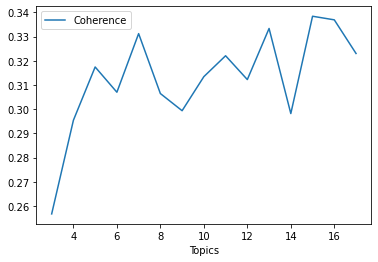

In [36]:
d = pd.DataFrame(model_results)
d.plot.line(x='Topics', y='Coherence')

Going with 7 topics for now

In [37]:
# basic hyperparameter tuning
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

tuned_results = {'Alpha': [], 'Beta': [], 'Coherence': []}

for a in alpha:
    for b in beta:
        cv = compute_coherence_values_and_tune(corpus=corpus, dictionary=id2word, k=7, a=a, b=b)
        tuned_results['Alpha'].append(a)
        tuned_results['Beta'].append(b)
        tuned_results['Coherence'].append(cv)

In [38]:
# hyperparameter values which give highest coherence
pd.DataFrame(tuned_results)[pd.DataFrame(tuned_results)['Coherence'] == max(tuned_results['Coherence'])]

,Alpha,Beta,Coherence
28,asymmetric,0.91,0.479214


In [39]:
# final model using tuned hyperparameters
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.9)

In [ ]:
# Print the keywords in the topics
pprint(lda_model.print_topics())

In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\Users\Nick\Documents\d998_nzski_sentiment_analysis\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.297733  0.030267       1        1  61.673592
1     -0.012278 -0.187069       2        1  12.177515
2      0.047903  0.070256       3        1  10.052312
5      0.038950  0.086812       4        1   8.027782
3      0.076272 -0.005209       5        1   3.572144
6      0.075687  0.002936       6        1   2.262434
4      0.071199  0.002007       7        1   2.234221, topic_info=            Term        Freq       Total Category  logprob  loglift
8          staff  547.000000  547.000000  Default  30.0000  30.0000
180        drive  578.000000  578.000000  Default  29.0000  29.0000
81          road  444.000000  444.000000  Default  28.0000  28.0000
210         food  356.000000  356.000000  Default  27.0000  27.0000
20    instructor  314.000000  314.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2523      screen    3.109029    9.750348   Topic7  -6.7000   2.6583
2880  worthwhile    1.956762    6.207075   Topic7  -7.1630   2.6469
2651     highway    2.752913   12.234961   Topic7  -6.8217   2.3096
850          men    2.301222    8.982522   Topic7  -7.0009   2.4394
833         bowl    4.072686   39.388553   Topic7  -6.4300   1.5321

[327 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1724      1  0.073824  abilities
1724      2  0.073824  abilities
1724      3  0.073824  abilities
1724      4  0.073824  abilities
1724      6  0.738240  abilities
...     ...       ...        ...
350       6  0.234536        wow
676       1  0.986345       year
676       2  0.004307       year
676       3  0.004307       year
676       4  0.004307       year

[1283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 6, 4, 7, 5])

Intertopic distance map shows not all topics nicely separated, still quite a bit of overlap in which keywords belong to which topic

[2_topic_modelling_lda_gensim_approach_3.html](./2_topic_modelling_lda_gensim_approach_3.html)

In [48]:
# saving the visualization
pyLDAvis.save_html(LDAvis_prepared, '3_topic_modelling_lda_gensim_approach_3.html')

##### 3b
Now building an NMF model (to try to distinguish the topics better)

In [41]:
tokenised_df.head()

,review_year,review_month,peak,tokenised_sentences,subjectivity,sentiment,sentiment_score
0,2021,Oct,cardrona,ticket process hire process be great easy all ...,0.569444,POSITIVE,0.990033
1,2021,Oct,cardrona,all be well until we meet out instructor (nick...,0.668750,NEGATIVE,-0.993660
2,2021,Oct,cardrona,it completely put our kid off.,0.400000,NEGATIVE,-0.995861
3,2021,Oct,cardrona,we then go do our own lesson with kid with lit...,0.566667,NEGATIVE,-0.938372
4,2021,Oct,cardrona,over all cadrona be well set up for first time...,0.477778,POSITIVE,0.970559


In [42]:
def remove_all_stopwords_and_extra_ones(text):
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

tokenised_df['tokenised_sentences'] = tokenised_df['tokenised_sentences'].apply(lambda x: remove_all_stopwords_and_extra_ones(x))
tokenised_df.head()

,review_year,review_month,peak,tokenised_sentences,subjectivity,sentiment,sentiment_score
0,2021,Oct,cardrona,ticket process hire process easy staff helpful...,0.569444,POSITIVE,0.990033
1,2021,Oct,cardrona,well meet instructor (nick) patience round gru...,0.668750,NEGATIVE,-0.993660
2,2021,Oct,cardrona,completely put kid off.,0.400000,NEGATIVE,-0.995861
3,2021,Oct,cardrona,go lesson kid little info get much well withou...,0.566667,NEGATIVE,-0.938372
4,2021,Oct,cardrona,cadrona well set first timer get wrong instruc...,0.477778,POSITIVE,0.970559


In [44]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b', ngram_range=(1,2), lowercase=False, 
min_df=5, # don't want terms to be used that don't appear often
stop_words='english' # not checking non-English stopwords for now
)
matrix = vectorizer.fit_transform(tokenised_df['tokenised_sentences'].values)

nmf = NMF(n_components=7, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd') # not tuned
nmf.fit(matrix)

c:\Users\Nick\Documents\d998_nzski_sentiment_analysis\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=7, random_state=1)

In [45]:
feature_names = vectorizer.get_feature_names()
n_top_words = 20

df_topic_dict = {}
for idx, topic in enumerate(nmf.components_[:10]):
    topic_id = f'topic_{idx+1}'
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    df_topic_dict[topic_id] = top_words
df_topic = pd.DataFrame(df_topic_dict)
df_topic

c:\Users\Nick\Documents\d998_nzski_sentiment_analysis\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,run,staff,snow,drive,lesson,mountain,experience
1,area,helpful,season,worth,instructor,drive mountain,year
2,beginner,friendly,lot,easy,day,bus,family
3,lift,staff friendly,plenty snow,road,kid,gear,come
4,slope,friendly helpful,lot snow,queenstown,private,beautiful,old
5,really,staff helpful,weather,worth drive,group,hire,year old
6,lot,helpful friendly,play,bus,private lesson,road,amaze
7,skier,friendly staff,make,trip,awesome,like,overall
8,resort,helpful staff,fresh,car,snowboard,biking,best
9,intermediate,super,plenty,easy drive,fantastic,mountain biking,amaze experience


We can see more distinguished topics now:
- topic 1: overall enjoyment/beginner-friendliness
- topic 2: staff (how friendly and helpful they were)
- topic 3: snow quality
- topic 4: commuting to the location
- topic 5: lesson quality
- topic 6 (less interpretable): equipment/views
- topic 7 (less interpretable): family-friendliness

After consulting with internal stakeholders who had more domain knowledge and expertise, it was determined that the main topics were:
- terrain
- customer service
- accessibility
- snow conditions
- lessons and instructions